1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по 1 месяцу.
2. Подберите параметры модели SARIMAX для этого ряда.
3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

In [20]:
import warnings
warnings.filterwarnings("ignore") 

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt

import itertools

In [21]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
df_m = df['PJME_MW'].resample("M").apply('mean')
df_m.head()

Date
2002-01-31    31075.399731
2002-02-28    30239.166667
2002-03-31    28875.256720
2002-04-30    28534.731572
2002-05-31    28073.653226
Freq: M, Name: PJME_MW, dtype: float64

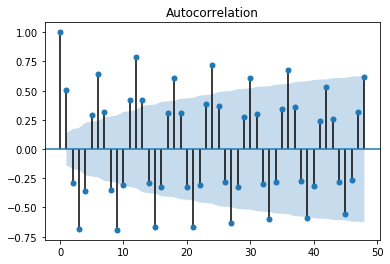

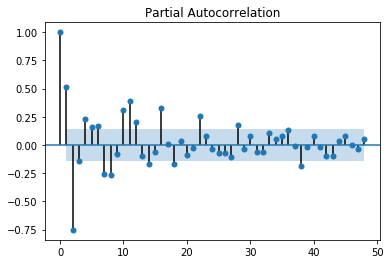

In [22]:
sm.graphics.tsa.plot_acf(df_m.values, lags=48)
plt.show()
sm.graphics.tsa.plot_pacf(df_m.values, lags=48)
plt.show()

Зададим длину сезона в один год (12 месяцев). Возьмём тестовую выборку как последний год.

In [25]:
import itertools
# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [26]:
models = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
            model = dict()
            mod = sm.tsa.statespace.SARIMAX(df_m.values[:-12],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            model['param'] = param, param_seasonal
            model['aic'] = results.aic
            # print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
            models.append(model)

In [28]:
sorted(models, key=lambda x: x['aic'])[0]

{'param': ((1, 1, 2), (1, 2, 2, 12)), 'aic': 2438.8077388238776}

In [32]:
# для построения модели используем все данные, кроме последнего года (это будет тестовый набор)
mod = sm.tsa.statespace.SARIMAX(df_m.values[:-12],order=[1,1,2],
                                seasonal_order=[1,2,2,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 2438.8077388238776


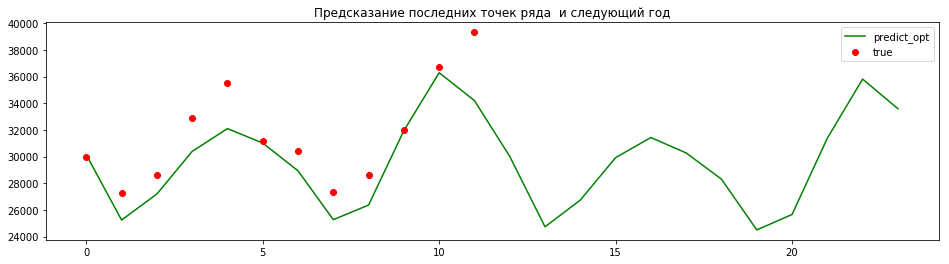

In [37]:
pred_dynamic_opt = results_opt.forecast(24)

plt.figure(figsize =(16,4))
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(df_m.values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующий год')
plt.legend()

plt.show()

По сравнению с недельным предсказанием, месячный выглядит более сглажено.